# Neural networks and deep learning

In this note, we implement neural networks and deep learning from scratch [[1]](#1).
We will train the network with the MNIST handwritten digit data.

Beginning with the cost function, we use the cross entropy function,
$$C = -\frac{1}{m}\sum_{i}^{m}\sum_{j}^{n}\big[ y_j^{(i)}\ln a_j^{L,(i)}+(1-y_j^{(i)})\ln(1-a_j^{L,(i)})\big]+\frac{\lambda}{2m}\sum_{l}^L\sum_{j}\sum_{k}(w^{l}_{jk})^2,$$
where $a_j^{L,(i)}$ is the activation of the $j$th output neuron,
$y_j^{(i)}$ is the (mini-batch) training data, corresponding to $j$th output, with size $m$, and
$w^{l}_{jk}$ is the weight connecting the $j$th neuron in the $l$th layer to the $k$th neuron in the $(l-1)$th layer. The last term is to regularize the neurons with the regularization parameter $\lambda$. 

The activation of the $j$th neuron in the $l$th layer is given by (repeated indices invoke the inner product, i.e., the Einstien notation),
$$a_j^l=\sigma(w^l_{jk}a^{l-1}_k+b^l_j)=\sigma(z^l_j),$$
where $b^l_j$ is the bias.<br>
Here, $\sigma(z^l_j)$ denotes the sigmoid function,
$$\sigma(z^l_j) = \frac{1}{1+e^{-z^l_j}}.$$

The weights and biases are optimized using (stochastic) gradient descent with back propagation,
$$
\begin{align}
\delta^L_j:=& \frac{\partial C}{\partial z^L_j}=\frac{1}{m}\sum_i^m(y_j^{(i)}-a^{L,(i)}_j)\\
\delta^l_j=& \frac{\partial C}{\partial z^l_j}=\frac{1}{m}\sum_i^m\delta^{l+1}_k w^{l+1}_{kj}\sigma'(z^{l,(i)}_j)=\frac{1}{m}\sum_i^m\delta^{l+1}_k w^{l+1}_{kj}a^{l,(i)}_j(1-a^{l,(i)}_j)\\
\frac{\partial C}{\partial w^l_{jk}}=& a^{l-1}_k\delta^l_j + \frac{\lambda}{m}w^l_{jk}\\
\frac{\partial C}{\partial b^l_{j}}=& \delta^l_j.
\end{align}
$$
Note that, from $\delta^L_j$, one can iteratively calculate $\delta^l_j$ down to the first hidden layer, thus the name "back propagation".

The weights and biases are updated with
$$
\begin{align}
w^l_{jk}&\to \bigg(1-\frac{\eta\lambda}{m}\bigg)w^l_{jk} -\frac{\eta}{m}\sum_i^m a^{l-1,(i)}_k\delta^{l,(i)}_j\\
b^l_{j}&\to b^l_{j} -\frac{\eta}{m}\sum_i^m \delta^{l,(i)}_j\\
\end{align}
$$
with $\eta$ being the learing rate.


## References
<a id="1">[1]</a> 
Michael Nielsen (2015). 
Neural Networks and Deep Learning.
http://neuralnetworksanddeeplearning.com

In [1]:
import numpy as np
import json
import sys
import matplotlib.pyplot as plt
import mnist_loader
import random

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def nabla_sigmod(z):
    """
    The derivative of sigmoid(z) with respect to z.
    """
    return sigmoid(z)*(1-sigmoid(z))
    
def map_results(y):
    """
    *** This function is specific to the handwritten number recognition problem! ***
    Mapping the desired label (0,1,2,...,9) to an array so that the machine can
    understand which output neuron has to be activated.
    For instance, if the correct label is 4, then the 4th entry of the array is 1
    while other entries are 0.
    -------------------------------------------------------------------------------
    y     : integer
            The desired output.
    -------------------------------------------------------------------------------
    return: array
            The vectorized desired output.
    """
    a = np.zeros((10,1))
    a[y] = 1.0
    return a
    

class NN():
    
    def __init__(self, size):
        """
        Initializing the neural networks.
        Note that the weights are initialized with random numbers drawn from
        a Gaussian distribution, and their variances are normalized by the number
        of neurons in the corresponding layer.
        ---------------------------------------------
        size: 1-d array
              The size of the networks.
              len(size) is the number of the layers.
              len(size)=3 means one input layer, one hidden layer,
              and one output layer.
              size[i] is the number of neurons of the i-th layer.
        """
        self.num_layers = len(size)
        self.size       = size
        
        self.biases     = [np.random.randn(i, 1) for i in self.size[1:]]
        self.weights    = [np.random.randn(i, j)/np.sqrt(j)
                           for i, j in zip(self.size[1:],self.size[:-1])]
        

    def CE(self,a, y):
        """
        The cross entropy function
        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1.0-y)*np.log(1.0-a)))

    def nabla_CE(self,a, y):
        """
        The derivative of CE(a,y) with respect to a.
        """
        return (a-y)        
        
    def propagate(self,a):
        """
        Propagating the activations of the input neurons to the output neurons.
        -----------------------------------------------------------------------
        input:  ndarray
                Activations of the input neurons.
        -----------------------------------------------------------------------
        return: ndarray
                Activations of the output neurons.
        
        """
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w,a)+b)
        return a
        
    def compute_cost(self, data, lamda, mapping=False):
        """
        Computing the total cost for the input data.
        When computing the cost of training phases, "mapping" has to be false.
        """
        cost = 0.0
        for x, y in data:
            a = self.propagate(x)
            if mapping: y = map_results(y)
            cost += self.CE(a, y)/len(data)
            # adding the regularization term
            cost += 0.5*(lamda/len(data))*sum(np.linalg.norm(w)**2 for w in
                                              self.weights)
        return cost
    
    def accuracy(self, data, mapping=False):
        """
        Computing the accuracy.
        
        """
        if mapping:
            temp = [(np.argmax(self.propagate(x)), np.argmax(y))
                   for x,y in data]
        else:
            temp = [(np.argmax(self.propagate(x)), y)
                   for x,y in data]
        return sum(int(x==y) for x,y in temp)
        
    def back_prop(self,x,y):
        """
        Returning nabla_b and nabla_w for the entire network.
        These numbers will then be used to update weights and biases.
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        activ  = x
        activs = [x]
        zs     = []
        
        # propagating the activations
        for b, w in zip(self.biases, self.weights):
            z     = np.dot(w, activ)+b
            activ = sigmoid(z)
            zs.append(z)
            activs.append(activ)
        
        # back propagating
        delta       = self.nabla_CE(activs[-1],y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activs[-2].T)
        for l in range(2, self.num_layers):
            z  = zs[-l]
            delta = np.dot(self.weights[-l+1].T, delta) * nabla_sigmod(z)
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activs[-l-1].T)
        return (nabla_b, nabla_w)
    
    def update_mini_batch(self, mini_batch, eta, lamda, m):
        """
        Updating the weights and biases for each mini batch.
        --------------------------------------------------------------
        mini_batch: list of tuples (x,y)
                    The list contains input (x) and output (y) traning data of
                    the mini batch
        m         : integer
                    The total size of the training data.
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            d_nabla_b, d_nabla_w = self.back_prop(x,y)
            nabla_b  = [nb+dnb for nb, dnb in zip(nabla_b, d_nabla_b)]
            nabla_w  = [nw+dnw for nw, dnw in zip(nabla_w, d_nabla_w)]
        self.weights = [(1-eta*(lamda/m))*w-(eta/len(mini_batch))*nw
                       for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases,  nabla_b)]
        
    def SGD(self, training_data, epochs, mini_batch_size, eta = 0.001, lamda = 0.0,
           evaluation_data = None,
           watch_eval_cost = False, watch_eval_accuracy = False,
           watch_training_cost = False, watch_training_accuracy = False):
        """
        Performing stochastic gradient descent (SGD).
        ---------------------------------------------------------------------
        training_data   : list of tuples (x,y)
                          x is the input data, and y the desired output.
        epochs          : integer
                          The number iterations for each batch.
        mini_batch_size : integer
                          The size of mini_batch.
        eta             : float (defualt = 0.001)
                          Learning rate.
        lamda           : float (defualt = 0.0)
                          Regularization parameter (or weight decay).
                          
        evaluation_data        : list of tuples (x,y) (defualt = None)
                                 Validation (or test) data.
        watch_eval_cost        : boolean (defualt = False)
                                 Returning the cost per epoch when validating.
        watch_eval_accuracy    : boolean (defualt = False)
                                 Returning the accuracy on the validation data
                                 per epoch.
        watch_training_cost    : boolean (defualt = False)
                                 Returning the cost per epoch while training.
        watch_training_accuracy: boolean (defualt = False)
                                 Returning the accuracy while training.
    
        """
        
        
        #training_data  = list(training_data)
        m              = len(training_data)
        
        if evaluation_data:
            #evaluation_data = list(evaluation_data)
            m_data          = len(evaluation_data)
            
        eval_cost, eval_accu         = [],[]
        training_cost, training_accu = [],[]
        # update weights and biases for mini batches
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size]
                           for k in range(0,m,mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, lamda, len(training_data))
                
            print(f"Epoch {j} training complete")
            
            if watch_eval_cost:
                cost = self.compute_cost(evaluation_data, lamda, mapping=True)
                eval_cost.append(cost)
                print(f"Cost on validation data: {cost:.3f}")
            if watch_training_cost:
                cost = self.compute_cost(training_data, lamda)
                training_cost.append(cost)
                print(f"Cost on training data: {cost:.3f}")
            if watch_eval_accuracy:
                accu = self.accuracy(evaluation_data)
                eval_accu.append(accu)
                print(f"Accuracy on validation data: {accu/m_data*100:.2f}%")
            if watch_training_accuracy:
                accu = self.accuracy(training_data, mapping=True)
                training_accu.append(accu)
                print(f"Accuracy on training data: {accu/m*100:.2f}%")
        
        return eval_cost, eval_accu, training_cost, training_accu
    
    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.size,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases]}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()
                
        
        
        
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.

    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    net = NN(data["sizes"])
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

In [2]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
training_data = list(training_data)
test_data     = list(test_data)
net = NN([784, 30, 10])
# epochs = 30, mini-batch size = 10, learning rate = 0.1, lambda = 0
_,acu,costs,_=net.SGD(training_data, 30, 10, 0.1, lamda=0, evaluation_data = test_data,
        watch_eval_accuracy=True, watch_training_cost = True)

net.save("MNIST_handwrite.neural")

Epoch 0 training complete
Cost on training data: 0.527
Accuracy on validation data: 92.45%
Epoch 1 training complete
Cost on training data: 0.420
Accuracy on validation data: 93.80%
Epoch 2 training complete
Cost on training data: 0.363
Accuracy on validation data: 94.57%
Epoch 3 training complete
Cost on training data: 0.335
Accuracy on validation data: 94.80%
Epoch 4 training complete
Cost on training data: 0.308
Accuracy on validation data: 95.19%
Epoch 5 training complete
Cost on training data: 0.283
Accuracy on validation data: 95.27%
Epoch 6 training complete
Cost on training data: 0.266
Accuracy on validation data: 95.50%
Epoch 7 training complete
Cost on training data: 0.258
Accuracy on validation data: 95.42%
Epoch 8 training complete
Cost on training data: 0.252
Accuracy on validation data: 95.44%
Epoch 9 training complete
Cost on training data: 0.246
Accuracy on validation data: 95.51%
Epoch 10 training complete
Cost on training data: 0.233
Accuracy on validation data: 95.66

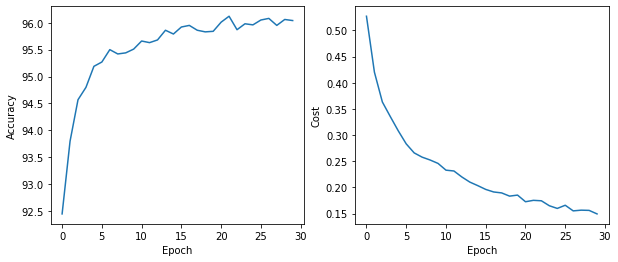

In [3]:
# Plot accuracy and cost
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,4))
ax0.plot(np.array(acu)/len(test_data)*100)
ax1.plot(costs)
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cost')
plt.show()

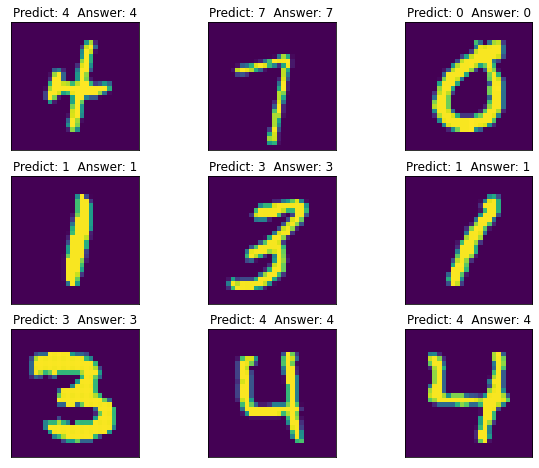

In [4]:
# Randomly pick 9 images from the test data
indices = (np.random.random(9)*len(test_data)).astype(int)

predic = []
for ind in indices:
    predic.append(np.argmax(net.propagate(test_data[ind][0])))

# Plot the randomly picked images with the corresponding predictions
fig, axes = plt.subplots(3,3,figsize = (10,8))
for i,ax in enumerate(axes.flatten()):
    ax.imshow(test_data[indices[i]][0].reshape(28,28))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Predict: {predic[i]}  '
                f'Answer: {test_data[indices[i]][1]}')